
# Generacion de Dataset


Descargar el dataset **Payments Fraud Detection** https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

# Importar librerías


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Cargar datos
Cargar el dataset

In [2]:
PATH_DATASET = "PS_20174392719_1491204439457_log.csv"

df = pd.read_csv(PATH_DATASET, delimiter=',')


### Analisis exploratorio

In [3]:
# Look at the dataset
# df.info()
# df.isnull().sum()   # No NaNs

# See 'step' feature
# plt.figure()
# plt.plot(df['step'])

# See 'nameOrig' and 'nameDest' feature
print('Unique Names:')
print('Origin:')
print(df['nameOrig'].value_counts(ascending=False).describe())
print('Destination:')
print(df['nameDest'].value_counts(ascending=False).describe())
print('---> Both origin and destination features show primarily unique accounts')

print('Dataset size: ', df.shape)
print('Columns: ', df.columns.to_list())
print('Types', df['type'].unique())
fraud_count = df['isFraud'].sum()
print('Frauds: ', ' (', (100*fraud_count/df.shape[0]).round(2), '%)')
print(df['isFraud'].value_counts(normalize=True))
print("---> Dataset is highly unbalanced")



Unique Names:
Origin:
count    6.353307e+06
mean     1.001466e+00
std      3.832002e-02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.000000e+00
Name: nameOrig, dtype: float64
Destination:
count    2.722362e+06
mean     2.337169e+00
std      4.549264e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.130000e+02
Name: nameDest, dtype: float64
---> Both origin and destination features show primarily unique accounts
Dataset size:  (6362620, 11)
Columns:  ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
Types ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
Frauds:   ( 0.13 %)
0    0.998709
1    0.001291
Name: isFraud, dtype: float64
---> Dataset is highly unbalanced


---> Acá vemos que el fraude suele incluir transferencias de cantidades altas
---> Solo se observa fraude con 2 tipos de transferencias: CASH_OUT y TRANSFER
isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64
---> Most features are weakly correlated with fraudulent transactions


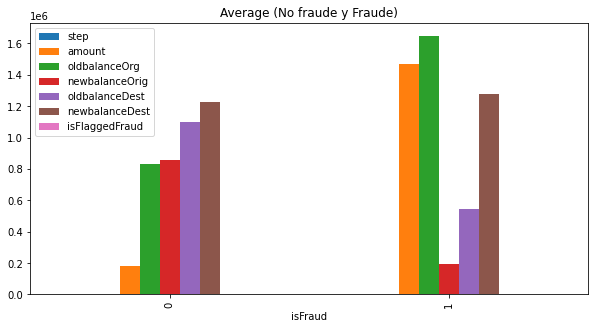

<Figure size 432x288 with 0 Axes>

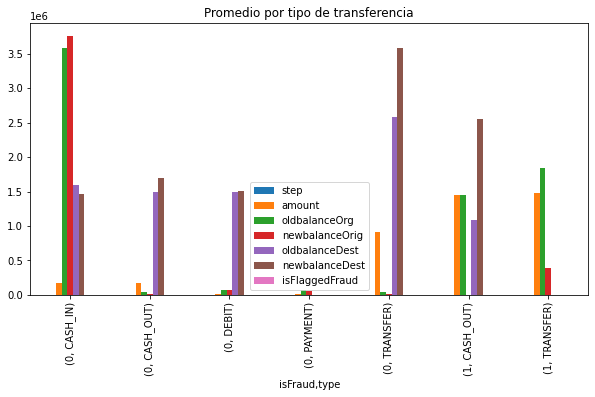

In [4]:
f_db = df.groupby('isFraud').mean()
f_db.plot(kind='bar', figsize=(10,5), title='Average (No fraude y Fraude)')
print('---> Acá vemos que el fraude suele incluir transferencias de cantidades altas')

fig = plt.figure()
t_db = df.groupby(['isFraud', 'type']).mean()
t_db.plot(kind='bar', figsize=(10,5), title='Promedio por tipo de transferencia')
print('---> Solo se observa fraude con 2 tipos de transferencias: CASH_OUT y TRANSFER')

# show Correlation
correlation = df.corr()
print(correlation['isFraud'].sort_values(ascending = False))
print("---> Most features are weakly correlated with fraudulent transactions")

# Feature selection


---> For our model, we can delete either new or old balance since they are highly correlated


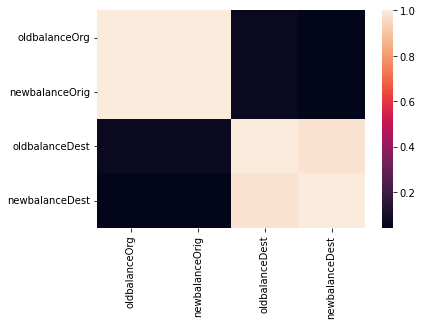

In [5]:
temp_df = df[['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
temp_corr = temp_df.corr()
sns.heatmap(temp_corr)
print('---> For our model, we can delete either new or old balance since they are highly correlated')

In [5]:
df_red = df
try:
    df_red = df_red.drop(['isFlaggedFraud'], axis=1)    # Remove flagged column. Will not be used.
    df_red = df_red.drop(['step'], axis=1)              # Step is strictly increasing timestamp. Remove since we will not analyze the dataset as time series.
    # df_red = df_red.drop(['nameOrig', 'nameDest'], axis=1)    # Remove names since we must be able to identify fraud for new accounts that do not have a history (also, not analyzed as time series)
    df_red = df_red.drop(['oldbalanceOrg', 'oldbalanceDest'], axis=1)    # Remove names since we must be able to identify fraud for new accounts that do not have a history (also, not analyzed as time series)
except:
    pass

print(df_red)

             type      amount     nameOrig  newbalanceOrig     nameDest  \
0         PAYMENT     9839.64  C1231006815       160296.36  M1979787155   
1         PAYMENT     1864.28  C1666544295        19384.72  M2044282225   
2        TRANSFER      181.00  C1305486145            0.00   C553264065   
3        CASH_OUT      181.00   C840083671            0.00    C38997010   
4         PAYMENT    11668.14  C2048537720        29885.86  M1230701703   
...           ...         ...          ...             ...          ...   
6362615  CASH_OUT   339682.13   C786484425            0.00   C776919290   
6362616  TRANSFER  6311409.28  C1529008245            0.00  C1881841831   
6362617  CASH_OUT  6311409.28  C1162922333            0.00  C1365125890   
6362618  TRANSFER   850002.52  C1685995037            0.00  C2080388513   
6362619  CASH_OUT   850002.52  C1280323807            0.00   C873221189   

         newbalanceDest  isFraud  
0                  0.00        0  
1                  0.00      

# Tratamiento de variables categóricas

In [6]:
x = df_red.drop(['isFraud'], axis=1)
y = df_red['isFraud']

# Transformamos variable de cuentas según frequencia de aparición
x_fre = x
type_freq_map = (x_fre['nameOrig'].value_counts() / len(x_fre)).to_dict()
x_fre['nameOrig'] = x_fre['nameOrig'].apply(lambda x: type_freq_map[x])
type_freq_map = (x_fre['nameDest'].value_counts() / len(x_fre)).to_dict()
x_fre['nameDest'] = x_fre['nameDest'].apply(lambda x: type_freq_map[x])
x=x_fre
print(x)


             type      amount      nameOrig  newbalanceOrig      nameDest  \
0         PAYMENT     9839.64  1.571680e-07       160296.36  1.571680e-07   
1         PAYMENT     1864.28  1.571680e-07        19384.72  1.571680e-07   
2        TRANSFER      181.00  1.571680e-07            0.00  6.915390e-06   
3        CASH_OUT      181.00  1.571680e-07            0.00  6.443886e-06   
4         PAYMENT    11668.14  1.571680e-07        29885.86  1.571680e-07   
...           ...         ...           ...             ...           ...   
6362615  CASH_OUT   339682.13  1.571680e-07            0.00  3.143359e-07   
6362616  TRANSFER  6311409.28  1.571680e-07            0.00  1.571680e-07   
6362617  CASH_OUT  6311409.28  1.571680e-07            0.00  4.715039e-07   
6362618  TRANSFER   850002.52  1.571680e-07            0.00  1.571680e-07   
6362619  CASH_OUT   850002.52  1.571680e-07            0.00  4.400703e-06   

         newbalanceDest  
0                  0.00  
1                  0.00

## One Hot Encoder

In [7]:
x_ohe = x
ohe_enc = OneHotEncoder(handle_unknown='ignore', drop=None, sparse=False)
ohe_df = pd.DataFrame(ohe_enc.fit_transform(x_ohe[['type']]), columns=ohe_enc.categories_[0])
x_ohe = x_ohe.join(ohe_df)
x_ohe = x_ohe.drop(columns=['type'], axis=0)

## Frecuency Encoder
Dado que la variable objetivo está relacionada a los tipos de transacciones CASH_OUT y TRANSFER, frequency encoder va a resaltar estos tipos de transacción para los modelos de predicción.

In [8]:
x_fre = x
type_freq_map = (x_fre['type'].value_counts() / len(x_fre)).to_dict()
x_fre['typeFreq'] = x_fre['type'].apply(lambda x: type_freq_map[x])

try:
    x_fre = x_fre.drop('type', axis=1)
except:
    pass

# Modelos

## Separación train-test

In [9]:
x_train_1_ohe_ub, x_test_1_ohe_ub, y_train_1_ohe_ub, y_test_1_ohe_ub = train_test_split(x_ohe, y, stratify = y, random_state=0)
x_train_1_ohe_ub = x_train_1_ohe_ub.reset_index(drop=True)
y_train_1_ohe_ub = y_train_1_ohe_ub.reset_index(drop=True)
print('Dataset OHE desbalanceado: ')
print('Train: ', x_train_1_ohe_ub.shape, 'Frauds: ', 100*y_train_1_ohe_ub.sum()/len(y_train_1_ohe_ub), '%')
print('Test: ', y_test_1_ohe_ub.shape, 'Frauds: ', 100*y_test_1_ohe_ub.sum()/len(y_test_1_ohe_ub), '%')

Dataset OHE desbalanceado: 
Train:  (4771965, 10) Frauds:  0.1290872837499856 %
Test:  (1590655,) Frauds:  0.1290663280221041 %


In [10]:
x_train_1_fre_ub, x_test_1_fre_ub, y_train_1_fre_ub, y_test_1_fre_ub = train_test_split(x_fre, y, stratify = y, random_state=0)
x_train_1_fre_ub = x_train_1_fre_ub.reset_index(drop=True)
y_train_1_fre_ub = y_train_1_fre_ub.reset_index(drop=True)
print('Dataset Frequency Encoder desbalanceado: ')
print('Train: ', x_train_1_fre_ub.shape, 'Frauds: ', 100*y_train_1_fre_ub.sum()/len(y_train_1_fre_ub), '%')
print('Test: ', y_test_1_fre_ub.shape, 'Frauds: ', 100*y_test_1_fre_ub.sum()/len(y_test_1_fre_ub), '%')

Dataset Frequency Encoder desbalanceado: 
Train:  (4771965, 6) Frauds:  0.1290872837499856 %
Test:  (1590655,) Frauds:  0.1290663280221041 %


## Modelo 1: OHE/FRE + Regresion lineal

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Función útil para ejecutar regresión lineal y ver los resultados
def RunLinearRegressor(x_train, x_test, y_train, y_test):
    scaler = StandardScaler()
    x_train_scaled=scaler.fit_transform(x_train) # Estandarizamos los datos     
        
    model=LogisticRegressionCV(scoring='f1')
    model.fit(x_train_scaled,y_train)

    x_test_scaled=scaler.transform(x_test)
    y_pred=model.predict(x_test_scaled)
    y_proba=model.predict_proba(x_test_scaled)
    
    plot_confusion_matrix(model,x_test_scaled,y_test)
    print(classification_report(y_test,y_pred))    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),3))    
    precision, recall, threshold=precision_recall_curve(y_test,y_proba[:,1])
    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),3))
    print(f'Precision:{precision}')
    print(f'Recall: {recall}:')

### Desbalanceados

#### OHE

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.78      0.07      0.13      2053

    accuracy                           1.00   1590655
   macro avg       0.89      0.53      0.56   1590655
weighted avg       1.00      1.00      1.00   1590655

Area bajo la curva ROC: 0.923
Area bajo la curva Precision-Recall: 0.169
Precision:[0.00129952 0.00129889 0.00129889 ... 0.         0.         1.        ]
Recall: [1.         0.99951291 0.99951291 ... 0.         0.         0.        ]:


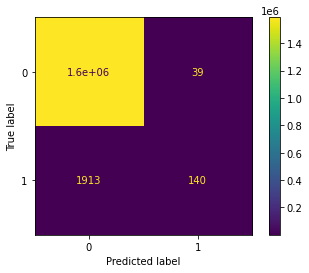

In [13]:
RunLinearRegressor(x_train_1_ohe_ub, x_test_1_ohe_ub, y_train_1_ohe_ub, y_test_1_ohe_ub)

#### FRE

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.55      0.06      0.10      2053

    accuracy                           1.00   1590655
   macro avg       0.77      0.53      0.55   1590655
weighted avg       1.00      1.00      1.00   1590655

Area bajo la curva ROC: 0.789
Area bajo la curva Precision-Recall: 0.119
Precision:[0.00129463 0.001294   0.001294   ... 0.         0.         1.        ]
Recall: [1.         0.99951291 0.99951291 ... 0.         0.         0.        ]:


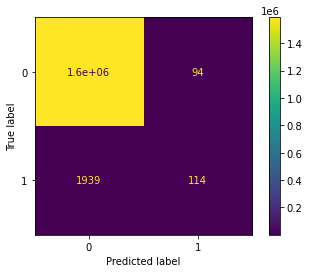

In [14]:
RunLinearRegressor(x_train_1_fre_ub, x_test_1_fre_ub, y_train_1_fre_ub, y_test_1_fre_ub)


### Balanceados (Undersampling)

In [21]:
from imblearn.under_sampling import RandomUnderSampler

undersampler=RandomUnderSampler(sampling_strategy='majority')

#### OHE

In [16]:
x_train_1_ohe_usampling, y_train_1_ohe_usampling = undersampler.fit_resample(x_train_1_ohe_ub, y_train_1_ohe_ub)
print('Composición del set de train:', len(x_train_1_ohe_usampling), 100*y_train_1_ohe_usampling.sum()/len(y_train_1_ohe_usampling), '%')

Composición del set de train: 12320 50.0 %


              precision    recall  f1-score   support

           0       1.00      0.75      0.86   1588602
           1       0.00      0.89      0.01      2053

    accuracy                           0.75   1590655
   macro avg       0.50      0.82      0.43   1590655
weighted avg       1.00      0.75      0.86   1590655

Area bajo la curva ROC: 0.922
Area bajo la curva Precision-Recall: 0.03
Precision:[0.00298276 0.00298131 0.00298131 ... 0.         0.         1.        ]
Recall: [1.         0.99951291 0.99951291 ... 0.         0.         0.        ]:


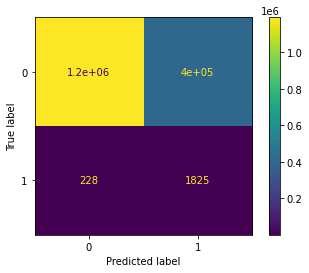

In [17]:
RunLinearRegressor(x_train_1_ohe_usampling, x_test_1_ohe_ub, y_train_1_ohe_usampling, y_test_1_ohe_ub)

#### FRE

In [18]:
x_train_1_fre_usampling, y_train_1_fre_usampling = undersampler.fit_resample(x_train_1_fre_ub, y_train_1_fre_ub)
print('Composición del set de train:', len(x_train_1_fre_usampling), 100*y_train_1_fre_usampling.sum()/len(y_train_1_fre_usampling), '%')

Composición del set de train: 12320 50.0 %


              precision    recall  f1-score   support

           0       1.00      0.89      0.94   1588602
           1       0.01      0.71      0.02      2053

    accuracy                           0.89   1590655
   macro avg       0.50      0.80      0.48   1590655
weighted avg       1.00      0.89      0.94   1590655

Area bajo la curva ROC: 0.843
Area bajo la curva Precision-Recall: 0.02
Precision:[0.00132006 0.00131942 0.00131942 ... 0.         0.         1.        ]
Recall: [1.         0.99951291 0.99951291 ... 0.         0.         0.        ]:


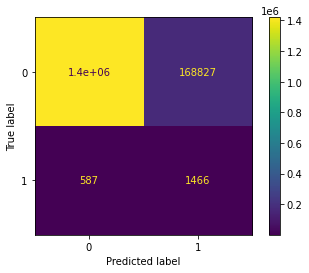

In [19]:
RunLinearRegressor(x_train_1_fre_usampling, x_test_1_fre_ub, y_train_1_fre_usampling, y_test_1_fre_ub)


### Balanceados (Oversampling)

In [12]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy=0.4)

#### OHE

In [13]:
x_train_1_ohe_osampling, y_train_1_ohe_osampling = oversampler.fit_resample(x_train_1_ohe_ub, y_train_1_ohe_ub)
print('Composición del set de train:', len(x_train_1_ohe_osampling), 100*y_train_1_ohe_osampling.sum()/len(y_train_1_ohe_osampling), '%')

Composición del set de train: 6672127 28.571428571428573 %


              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1588602
           1       0.02      0.67      0.03      2053

    accuracy                           0.94   1590655
   macro avg       0.51      0.81      0.50   1590655
weighted avg       1.00      0.94      0.97   1590655

Area bajo la curva ROC: 0.924
Area bajo la curva Precision-Recall: 0.041
Precision:[0.00299824 0.00299678 0.00299678 ... 0.         0.         1.        ]
Recall: [1.         0.99951291 0.99951291 ... 0.         0.         0.        ]:


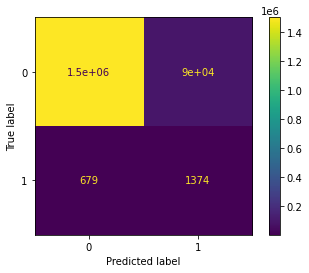

In [15]:
RunLinearRegressor(x_train_1_ohe_osampling, x_test_1_ohe_ub, y_train_1_ohe_osampling, y_test_1_ohe_ub)

#### FRE

In [ ]:
x_train_1_fre_osampling, y_train_1_fre_osampling = oversampler.fit_resample(x_train_1_fre_ub, y_train_1_fre_ub)
print('Composición del set de train:', len(x_train_1_ohe_osampling), 100*y_train_1_fre_osampling.sum()/len(y_train_1_fre_osampling), '%')

Composición del set de train: 6672127 28.571428571428573 %


c:\Users\mdevo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1588602
           1       0.01      0.47      0.03      2053

    accuracy                           0.95   1590655
   macro avg       0.51      0.71      0.50   1590655
weighted avg       1.00      0.95      0.98   1590655

Area bajo la curva ROC: 0.841
Area bajo la curva Precision-Recall: 0.025
Precision:[0.00131061 0.00130998 0.00130998 ... 0.         0.         1.        ]
Recall: [1.         0.99951291 0.99951291 ... 0.         0.         0.        ]:


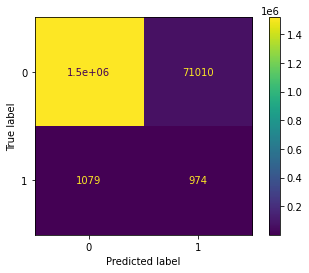

In [ ]:
RunLinearRegressor(x_train_1_fre_osampling, x_test_1_fre_ub, y_train_1_fre_osampling, y_test_1_fre_ub)

# Modelo 2: OHE + Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Función útil para ejecutar regresión lineal y ver los resultados
def RunRandomForest(x_train, x_test, y_train, y_test):
        
    model=RandomForestClassifier(n_estimators = 100, max_depth = 15, random_state=0)
    model.fit(x_train, y_train)

    y_pred=model.predict(x_test)
    y_proba=model.predict_proba(x_test)
    
    print(classification_report(y_test,y_pred))    
    cfm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()

### Balanceado (Undersampling)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1588602
           1       0.01      0.86      0.02      2053

    accuracy                           0.91   1590655
   macro avg       0.51      0.89      0.49   1590655
weighted avg       1.00      0.91      0.95   1590655



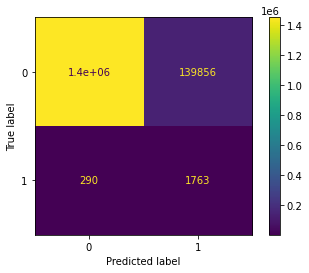

In [ ]:
RunRandomForest(x_train_1_ohe_usampling, x_test_1_ohe_ub, y_train_1_ohe_usampling, y_test_1_ohe_ub)

# AutoML

In [23]:
import mlflow
from pycaret.classification import *
from pycaret.datasets import get_data
# mlflow.autolog()

## OHE Undersampling

In [22]:
x_ohe_usampling, y_ohe_usampling = undersampler.fit_resample(x_ohe, y)

In [ ]:
# Join x and y into one dataframe
df_auto = pd.concat([x_ohe_usampling, y_ohe_usampling], axis=1)
clf1 = setup(df_auto, target = 'isFraud', log_experiment = True, experiment_name = 'exp1_ohe_usampling', use_gpu=True, silent=True)

,Description,Value
0,session_id,8656
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(16426, 11)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


2022/08/17 12:48:43 INFO mlflow.tracking.fluent: Experiment with name 'exp1_ohe_usampling' does not exist. Creating a new experiment.


In [ ]:
exp1_models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8937,0.9720,0.8710,0.9132,0.8914,0.7875,0.7885,1.4290
lightgbm,Light Gradient Boosting Machine,0.8905,0.9714,0.8712,0.9067,0.8885,0.7810,0.7817,3.2620
rf,Random Forest Classifier,0.8862,0.9679,0.8696,0.8999,0.8844,0.7723,0.7729,1.2240
ada,Ada Boost Classifier,0.8813,0.9648,0.8614,0.8979,0.8791,0.7626,0.7636,0.6290
et,Extra Trees Classifier,0.8813,0.9635,0.8670,0.8930,0.8797,0.7626,0.7631,1.4700
dt,Decision Tree Classifier,0.8675,0.8675,0.8680,0.8676,0.8677,0.7349,0.7350,0.0590
knn,K Neighbors Classifier,0.8151,0.8957,0.8053,0.8221,0.8135,0.6302,0.6306,0.5630
lda,Linear Discriminant Analysis,0.8020,0.9139,0.9177,0.7459,0.8228,0.6038,0.6210,0.0560
ridge,Ridge Classifier,0.7827,0.0000,0.9887,0.7007,0.8201,0.5650,0.6202,0.0290
lr,Logistic Regression,0.6779,0.8496,0.9118,0.6219,0.7394,0.3554,0.4019,0.0690


## OHE Oversampling

In [16]:
oversampler_2 = RandomOverSampler(sampling_strategy=0.2)
x_ohe_osampling, y_ohe_osampling = oversampler_2.fit_resample(x_ohe, y)

In [25]:
# Join x and y into one dataframe
df_auto = pd.concat([x_ohe_osampling, y_ohe_osampling], axis=1)
clf1 = setup(df_auto, target = 'isFraud', log_experiment = True, experiment_name = 'exp2_ohe_osampling', use_gpu=True, silent=True)

,Description,Value
0,session_id,6933
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(7625288, 11)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


2022/08/24 22:37:26 INFO mlflow.tracking.fluent: Experiment with name 'exp2_ohe_osampling' does not exist. Creating a new experiment.


In [ ]:
exp2_models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8937,0.9720,0.8710,0.9132,0.8914,0.7875,0.7885,1.4290
lightgbm,Light Gradient Boosting Machine,0.8905,0.9714,0.8712,0.9067,0.8885,0.7810,0.7817,3.2620
rf,Random Forest Classifier,0.8862,0.9679,0.8696,0.8999,0.8844,0.7723,0.7729,1.2240
ada,Ada Boost Classifier,0.8813,0.9648,0.8614,0.8979,0.8791,0.7626,0.7636,0.6290
et,Extra Trees Classifier,0.8813,0.9635,0.8670,0.8930,0.8797,0.7626,0.7631,1.4700
dt,Decision Tree Classifier,0.8675,0.8675,0.8680,0.8676,0.8677,0.7349,0.7350,0.0590
knn,K Neighbors Classifier,0.8151,0.8957,0.8053,0.8221,0.8135,0.6302,0.6306,0.5630
lda,Linear Discriminant Analysis,0.8020,0.9139,0.9177,0.7459,0.8228,0.6038,0.6210,0.0560
ridge,Ridge Classifier,0.7827,0.0000,0.9887,0.7007,0.8201,0.5650,0.6202,0.0290
lr,Logistic Regression,0.6779,0.8496,0.9118,0.6219,0.7394,0.3554,0.4019,0.0690


# Conclusiones

Para decidir sobre el mejor modelo, se consideraron las metricas Precision, Recall y F1-Score.
$$ Precision = \frac{True\ Positive}{True\ Positive + False\ Positive} $$
$$ Recall = \frac{True\ Positive}{Total\ Actual\ Positive} $$
$$ F1Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} $$

Ya que se trata de intentar detectar fraudes bancarios, es sumamente importante que haya la menor cantidad de falsos negativos, es decir, minimizar la cantidad de casos que se declaran no fraudulentos cuando en realidad sí lo eran. 
Por esta razón, se prioriza la métrica Recall como la más significativa, ya que un recall menor a 1 significaría que hay casos positivos que no se detectaron. 

Utilizando la métrica Recall, los mejores resultaron se obtuvieron con los modelos de Random Forest con Undersampling